# Bayesian regression for storm erosion prediction
Joshua Simmons 05/2022

Further ideas:
 - https://nbviewer.org/github/pyro-ppl/numpyro/blob/master/notebooks/source/bayesian_regression.ipynb

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%pdb 1
%matplotlib inline

Automatic pdb calling has been turned ON


## Imports and settings

In [21]:
import os, sys
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import urllib.request
sns.set_style('whitegrid')
sns.set_context('talk')

from ipywidgets import interactive, fixed, widgets

# MAP regression
import sklearn.linear_model as lm

#numpyro
from jax import random
import jax.numpy as jnp
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive


## Download wave data

In [3]:
rawWaveData = pd.read_csv('combined_era_data_-34.0_151.5.csv',index_col=0,parse_dates=True)
rawWaveData

,Hsig,Dm,Tm,Tp
1985-01-01 00:00:00+00:00,2.939188,145.469954,9.525881,11.604365
1985-01-01 01:00:00+00:00,2.877766,146.167504,9.486316,11.335198
1985-01-01 02:00:00+00:00,2.812836,146.744218,9.450154,11.166937
1985-01-01 03:00:00+00:00,2.742849,147.095740,9.419097,11.045749
1985-01-01 04:00:00+00:00,2.668457,147.315440,9.399669,10.950101
...,...,...,...,...
2022-05-17 17:00:00+00:00,1.063330,216.221455,5.628918,8.098916
2022-05-17 18:00:00+00:00,1.077575,220.109573,5.572868,8.056106
2022-05-17 19:00:00+00:00,1.096806,223.608331,5.509447,8.006692
2022-05-17 20:00:00+00:00,1.127195,226.679341,5.431422,7.953862


## Download shoreline data

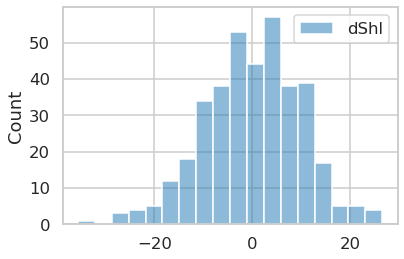

In [4]:
transectName = 'aus0206-0005'
csSource = 'http://coastsat.wrl.unsw.edu.au/time-series/{}/'
tmpLoc =  "working_data.csv"
download = False

if download:
    urllib.request.urlretrieve(csSource.format(transectName), tmpLoc)

rawShlData = pd.read_csv(tmpLoc,parse_dates=True,index_col=0,header=None)
rawShlData.index = pd.to_datetime(rawShlData.index,utc=True)
rawShlData.columns = ['Shoreline']
rawShlData.index.name = 'Date'
# shlData.plot()

diffShlData = rawShlData.diff()
diffShlData.columns = ['dShl'] 

sns.histplot(diffShlData.dropna())
None

## Convert to storm dataset

In [5]:
def calculate_wave_energy(waveIn):
    rho = 1025 # kg/m^3
    g = 9.81 # m/s^2
    # this needs to be more robust
    dt = (waveIn.index[1] - waveIn.index[0]).seconds/3600
    stormCriteria = waveIn['Hsig']>3.0 #m
    energy = np.sum(waveIn.loc[stormCriteria,'Hsig']**2)*rho*g*dt*(1/16)
    return energy

In [6]:
# Prepare the diffShlData df
shlData = rawShlData.diff().copy()
shlData['postDate'] = shlData.index
shlData.loc[shlData.index[1:],'preDate'] = shlData.index[:-1]
shlData.drop(shlData.index[0],inplace=True)
shlData.index = ['Storm_{0:04.0f}'.format(_) for _ in range(shlData.shape[0])]
shlData

,Shoreline,postDate,preDate
Storm_0000,24.1,1987-09-11 23:10:29+00:00,1987-05-22 23:07:44+00:00
Storm_0001,12.2,1987-09-27 23:10:51+00:00,1987-09-11 23:10:29+00:00
Storm_0002,-19.0,1988-02-18 23:13:23+00:00,1987-09-27 23:10:51+00:00
Storm_0003,-16.9,1988-06-09 23:14:15+00:00,1988-02-18 23:13:23+00:00
Storm_0004,2.0,1988-06-25 23:14:20+00:00,1988-06-09 23:14:15+00:00
...,...,...,...
Storm_0427,13.1,2019-07-17 23:44:04+00:00,2019-07-09 23:32:23+00:00
Storm_0428,-5.7,2019-08-02 23:44:11+00:00,2019-07-17 23:44:04+00:00
Storm_0429,-4.8,2019-08-10 23:31:06+00:00,2019-08-02 23:44:11+00:00
Storm_0430,15.2,2019-08-18 23:44:16+00:00,2019-08-10 23:31:06+00:00


In [7]:
# split the wave data according to the shoreline data
waveData = {}
for thisStorm in shlData.index:
    waveData[thisStorm] = rawWaveData.loc[shlData.loc[thisStorm,'preDate']:shlData.loc[thisStorm,'postDate']]
    shlData.loc[thisStorm,'E'] = calculate_wave_energy(waveData[thisStorm])
waveData[thisStorm]
shlData

,Shoreline,postDate,preDate,E
Storm_0000,24.1,1987-09-11 23:10:29+00:00,1987-05-22 23:07:44+00:00,7.859642e+05
Storm_0001,12.2,1987-09-27 23:10:51+00:00,1987-09-11 23:10:29+00:00,0.000000e+00
Storm_0002,-19.0,1988-02-18 23:13:23+00:00,1987-09-27 23:10:51+00:00,1.476329e+06
Storm_0003,-16.9,1988-06-09 23:14:15+00:00,1988-02-18 23:13:23+00:00,1.420433e+06
Storm_0004,2.0,1988-06-25 23:14:20+00:00,1988-06-09 23:14:15+00:00,8.754280e+04
...,...,...,...,...
Storm_0427,13.1,2019-07-17 23:44:04+00:00,2019-07-09 23:32:23+00:00,0.000000e+00
Storm_0428,-5.7,2019-08-02 23:44:11+00:00,2019-07-17 23:44:04+00:00,0.000000e+00
Storm_0429,-4.8,2019-08-10 23:31:06+00:00,2019-08-02 23:44:11+00:00,0.000000e+00
Storm_0430,15.2,2019-08-18 23:44:16+00:00,2019-08-10 23:31:06+00:00,6.888425e+04


In [8]:
# constrain shlData by adding consective shoreline movements
# print(shlData)
shlData['zeroCross'] = np.sign(shlData['Shoreline']).diff().ne(0).astype(int)
shlData['zeroCross'] = shlData['zeroCross'].cumsum()
groupedVals = shlData.groupby(by='zeroCross',as_index=False).sum()
groupedVals.index = shlData.index[[np.where(shlData['zeroCross'] == _)[0][0] for _ in groupedVals['zeroCross']]]
shlData['E'] = groupedVals['E']
shlData['Shoreline'] = groupedVals['Shoreline']
shlData.drop_duplicates(subset=['zeroCross'],inplace=True)
shlData

,Shoreline,postDate,preDate,E,zeroCross
Storm_0000,36.3,1987-09-11 23:10:29+00:00,1987-05-22 23:07:44+00:00,7.859642e+05,1
Storm_0002,-35.9,1988-02-18 23:13:23+00:00,1987-09-27 23:10:51+00:00,2.896762e+06,2
Storm_0004,11.1,1988-06-25 23:14:20+00:00,1988-06-09 23:14:15+00:00,3.235231e+05,3
Storm_0006,-7.6,1988-08-12 23:14:25+00:00,1988-07-27 23:14:26+00:00,7.529556e+05,4
Storm_0007,7.2,1988-08-28 23:14:30+00:00,1988-08-12 23:14:25+00:00,2.659782e+05,5
...,...,...,...,...,...
Storm_0425,-20.9,2019-05-30 23:43:50+00:00,2019-05-22 23:34:09+00:00,0.000000e+00,291
Storm_0426,21.4,2019-07-09 23:32:23+00:00,2019-05-30 23:43:50+00:00,5.652673e+05,292
Storm_0428,-10.5,2019-08-02 23:44:11+00:00,2019-07-17 23:44:04+00:00,0.000000e+00,293
Storm_0430,15.2,2019-08-18 23:44:16+00:00,2019-08-10 23:31:06+00:00,6.888425e+04,294


## Plot the data

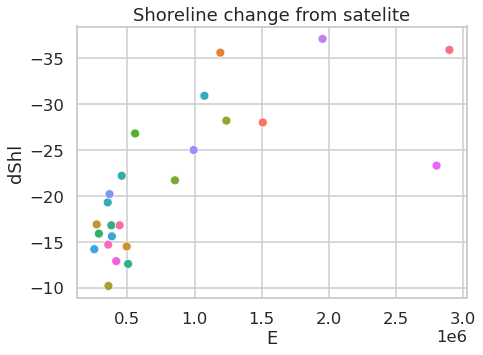

In [9]:
# clean the data
plotData = shlData.dropna().copy()
plotData = plotData.loc[(plotData['E']>250000) & (plotData['Shoreline']<-5)]
plotData = plotData.drop(plotData.index[(plotData['E']>600000) & (plotData['Shoreline']>-20)])

x, y = plotData['E'].values, -plotData['Shoreline'].values

# and trasnform to logspace
x_log = np.log(x)
y_log = np.log(y)

log_scale=False
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_subplot(111)

sns.scatterplot(x='E',y='Shoreline',hue='preDate',data=plotData,ax=ax1)

ax1.set_xlabel('E')
ax1.set_ylabel('dShl')
ax1.invert_yaxis()
# change axes to log - log scale
if log_scale:
    plt.xscale('log')
    plt.yscale('log')
plt.title('Shoreline change from satelite')
ax1.get_legend().remove()
# plt.legend(loc='center', bbox_to_anchor=(1.5,0.5))
plt.show()

## Generate toy data

In [10]:
# Generate data that follows a power law distribution
# y = a * x^b + error
#defaults
powa = 0.05
constb = 1.5
err_var = 0.15
hs_scale = 0
# Plot x, y data

def generate_data(powa, constb, err_var, hs_scale, n_points, log_scale=False):
    print('Choose a and b in y = a * x^b')
    x = np.around(np.random.uniform(0, 10, n_points),decimals=2)

    # generate the error
    err = np.random.normal(0, err_var, len(x))
    # add a homoscedastic error
    err += (err * x) * hs_scale


    y = (powa * x**constb) + err

    plt.plot(x, y, 'o',label='Data')
    xReal = np.linspace(0,10,100)
    yReal = powa * xReal**constb
    plt.plot(xReal,yReal,'r-',label='True function')

    plt.xlabel('x')
    plt.ylabel('y')
    # change axes to log - log scale
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')
    plt.title('Power Law Distribution')
    plt.legend(loc='center', bbox_to_anchor=(1.1,0.5))
    plt.show()

    return x, y

result = interactive(
    generate_data,
    powa = widgets.FloatText(value=powa,description='a',step=0.05), 
    constb = widgets.FloatText(value=constb,description='b',step=0.5),
    err_var = widgets.FloatText(value=err_var,description='variance',step=0.05),
    hs_scale = widgets.FloatText(value=hs_scale,description='homoscedasticity',step=0.05),
    n_points = widgets.IntSlider(value=5,min=5,max=100,step=5,description='n_points'),
    log_scale=False
)

display(result)



interactive(children=(FloatText(value=0.05, description='a', step=0.05), FloatText(value=1.5, description='b',…

In [11]:
x, y = result.result
print('x: {}\ny: {}'.format(x.shape,y.shape))

# and trasnform to logspace
x_log = np.log(x)
y_log = np.log(y)

x: (5,)
y: (5,)


## Setup plotting functions

In [10]:
def draw_fit(xObs,yObs,xPred,yPred,ySample=None,yMAP=None,**kwargs):
    fig = plt.figure(figsize=(7, 5))
    ax1 = fig.add_subplot(111)

    # if kwargs.get('errBands',False):
    #     ax1.fill_between(xSample, predyMean - 1.96*predyStd, predyMean + 1.96*predyStd, alpha=0.2,label='95% CI')
    #     ax1.plot(xSample, sampleyMean[:,0],label='Samples')
    #     ax1.plot(xSample, sampleyMean[:,1:])
    # else:
    #     ax1.plot(xSample, sampleyMean)#,label='Samples')

    if not ySample is None:
        ax1.plot(xPred, ySample[0,:].T,'-',color='xkcd:light grey',alpha=0.4,label='Samples')
        ax1.plot(xPred, ySample[1:,:].T,'-',color='xkcd:light grey',alpha=0.4)

    if not yMAP is None:
        ax1.plot(xPred, yMAP.T,'-',color='xkcd:red',label='MAP fit')

    # # plot mean
    # ax1.plot(xSample, predyMean, 'k', label='Mean')

    # if not y is None:
    ax1.plot(xObs, yObs, 'o',color='xkcd:dark grey',label='Observed')
    ax1.plot(xPred, yPred, 'C0', label='Predicted')
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    if kwargs.get('log_scale',False):
        ax1.set_xscale('log')
        ax1.set_yscale('log')

    ax1.set_title(kwargs.get('title','Power Law Distribution Fit'))
    # place legend outside the plot
    plt.legend(loc='center', bbox_to_anchor=(1.2, 0.5))
    plt.show()
    return ax1

## Fit a Bayesian Linear Regression in logspace - MAP

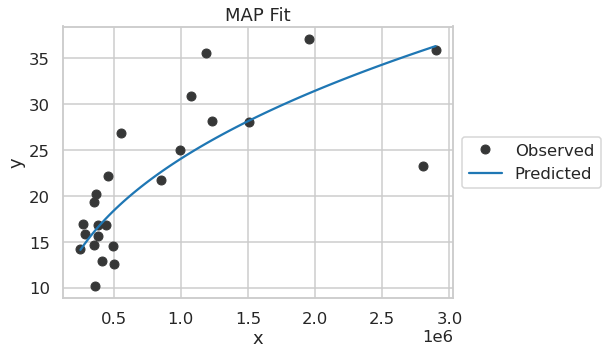

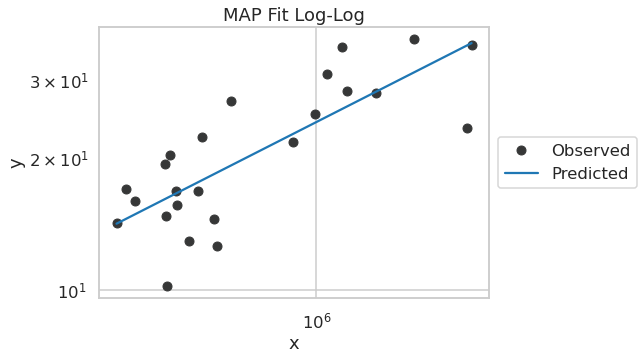

In [11]:
# fit a linear model to the data
model = lm.LinearRegression()
model.fit(x_log.reshape(-1,1),y_log)

sample_x = np.linspace(x.min(),x.max(),101)

y_pred = model.predict(np.log(sample_x).reshape(-1,1))

draw_fit(x,y,sample_x,np.exp(y_pred),title='MAP Fit')

draw_fit(x,y,sample_x,np.exp(y_pred),log_scale=True,title='MAP Fit Log-Log')

None

## Fit with pymc3

In [40]:
def linear_model(energy=None,dshl=None):
    '''
    Define linear model with priors for the parameters and model error
    '''
    # Define priors
    coeff1 = numpyro.sample("coeff1",dist.Normal(0, 10))
    intercept = numpyro.sample("intercept",dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))

    mu_out = coeff1 * energy + intercept
    dshl_modelled = numpyro.sample("dshl_modelled", dist.Normal(mu_out, sigma), obs=dshl)

In [36]:
# settings 
num_samples = 10000
burnin = int(0.25 * num_samples)
ci = 0.95

# Random number generator - jax style
rng_key = random.PRNGKey(2022)
rng_key, rng_key_ = random.split(rng_key)

# define the sampler
kernel = NUTS(linear_model)

# define the mcmc wrapper
mcmc_obj = MCMC(kernel, num_warmup=burnin, num_samples=num_samples)

mcmc_obj.run(
    rng_key_, energy=x_log, dshl=y_log
)
mcmc_obj.print_summary()
samples = mcmc_obj.get_samples()

sample: 100%|██████████| 12500/12500 [00:14<00:00, 834.64it/s, 63 steps of size 7.16e-02. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     coeff1      0.01      0.00      0.01      0.01      0.02   2794.40      1.00
  intercept      0.47      0.46      0.47     -0.36      1.17   2790.51      1.00
      sigma      0.25      0.04      0.24      0.19      0.31   2777.49      1.00

Number of divergences: 0


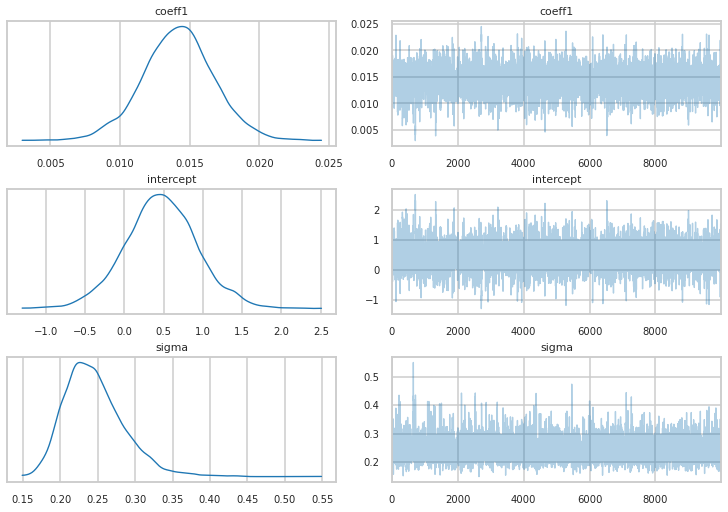

In [37]:
posterior_predictive = Predictive(linear_model, samples)(
    rng_key_, energy=x_log, dshl=y_log
)
# predictions =  posterior_predictive(rng_key_, energy=x_log)["dshl_modelled"]
prior = Predictive(linear_model, num_samples=100)(
    rng_key_, energy=x_log, dshl=y_log
)

numpyro_data = az.from_numpyro(
    mcmc_obj,
    prior=prior,
    posterior_predictive=posterior_predictive,
    # coords={"school": np.arange(eight_school_data["J"])},
    # dims={"theta": ["school"]},
)
numpyro_data
az.plot_trace(numpyro_data,figsize=(10,7))
None

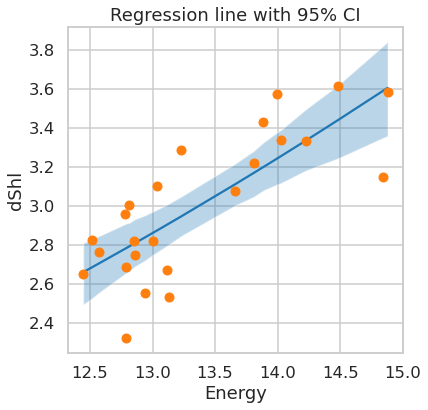

In [38]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = np.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = y_log[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax


# Compute empirical posterior distribution over mu
posterior_mu = (
    jnp.expand_dims(samples["intercept"], -1)
    + jnp.expand_dims(samples["coeff1"], -1) * x_log
)

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, ci)
ax = plot_regression(x_log, mean_mu, hpdi_mu)
ax.set(
    xlabel="Energy", ylabel="dShl", title="Regression line with 95% CI"
)
None

In [39]:
nSamples = 100

# generate draws from the posterior
eval_lm = lambda x, sample: sample["Intercept"] + sample["x"] * x
if not isinstance(trace, list):
    trace = trace.posterior.to_dataframe().to_dict(orient="records")
ySample = np.zeros((nSamples, len(sample_x)))
for ii, rand_loc in enumerate(np.random.randint(0, len(trace), nSamples)):
    rand_sample = trace[rand_loc]
    tmpSample = eval_lm(np.log(sample_x), rand_sample)
    ySample[ii,:] = tmpSample

mapParams = pm.find_MAP(model=model)
yMAP = eval_lm(np.log(sample_x), mapParams)

draw_fit(
    x,y,
    sample_x,np.full(sample_x.shape, np.nan),
    ySample=np.exp(ySample),yMAP=np.exp(yMAP),
    title='Fit with uncertainty')

draw_fit(
    x,y,
    sample_x,np.full(sample_x.shape, np.nan),
    ySample=np.exp(ySample),yMAP=np.exp(yMAP),
    log_scale=True,title='Log-Log fit with uncertainty')

None


NameError: name 'trace' is not defined

> /tmp/ipykernel_520/3207217677.py(5)<cell line: 5>()
      3 # generate draws from the posterior
      4 eval_lm = lambda x, sample: sample["Intercept"] + sample["x"] * x
----> 5 if not isinstance(trace, list):
      6     trace = trace.posterior.to_dataframe().to_dict(orient="records")
      7 ySample = np.zeros((nSamples, len(sample_x)))

